In [1]:
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci

raw = mne.io.read_raw_bdf("C:\\Users\\pipo_\\OneDrive\\Desktop\\test_data\\Testdata2.bdf", preload=True, verbose=False)
raw = raw.resample(512, verbose = False)

eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("biosemi64")

raw.set_montage(montage, on_missing='ignore')

Measurement date,"August 16, 2024 15:38:40 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"72 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


Effective window size : 4.000 (s)


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


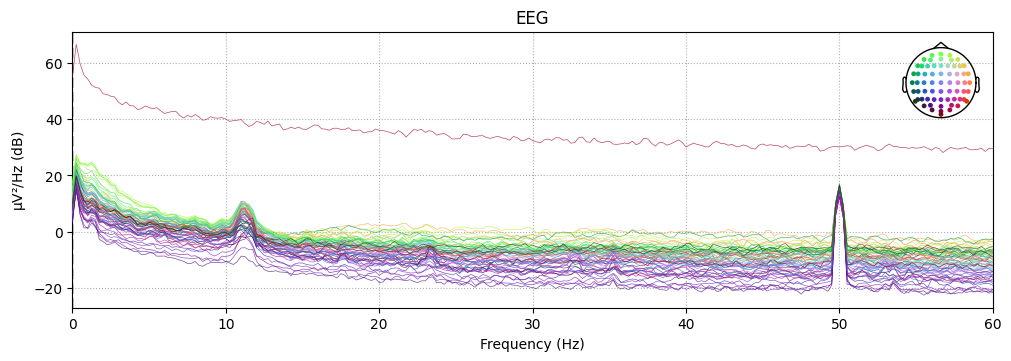

In [2]:
raw.compute_psd(fmax=60).plot(picks=raw.ch_names[0:64])
plt.show()

In [3]:
# Bandpass filter 

raw = raw.copy().notch_filter(freqs=50)

raw = raw.copy().filter(l_freq=1, h_freq=40, verbose = False)

events_raw = mne.find_events(raw, shortest_event = 0)
# events = np.delete(events_raw, [0, 1 ,4], axis= 0) #remove first event because that is power status
events = events_raw

event_dict =  {'12Hz': 2,
'24Hz': 4,
'6Hz': 8,
'30Hz': 10,
'trial_begin': 1,
'trial_end': 20,
'end_exper': 40
}

events

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.1s finished


Trigger channel STATUS has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
66 events found on stim channel STATUS
Event IDs: [    1     2     4     8    10    20    40 65537]


array([[   420,  65536,  65537],
       [   933,      0,     10],
       [  3492,      0,     20],
       [  4518,      0,      1],
       [  5030,      0,      8],
       [ 24043,      0,      1],
       [ 24554,      0,      4],
       [ 27115,      0,     20],
       [ 28140,      0,      1],
       [ 28653,      0,      8],
       [ 31212,      0,     20],
       [ 32237,      0,      1],
       [ 32749,      0,      2],
       [ 35310,      0,     20],
       [ 36335,      0,      1],
       [ 36848,      0,      4],
       [ 39407,      0,     20],
       [ 40432,      0,      1],
       [ 40945,      0,     10],
       [ 43505,      0,     20],
       [ 44530,      0,      1],
       [ 45043,      0,      4],
       [ 47602,      0,     20],
       [ 48626,      0,      1],
       [ 49139,      0,      4],
       [ 51700,      0,     20],
       [ 52724,      0,      1],
       [ 53236,      0,     10],
       [ 55796,      0,     20],
       [ 56821,      0,      1],
       [ 5

In [4]:
Epochs = mne.Epochs(raw, events, 
    tmin= -1.0,  
    tmax= 4.0,    
    event_id=event_dict,
    preload = True,
    event_repeated='drop',
    baseline=(-1.0, 0.0),
    verbose=True
    )

Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 65 events and 2561 original time points ...
0 bad epochs dropped


In [6]:
import pickle
with open('SSVEP_test_epochs.pkl', 'wb') as f:
    pickle.dump(Epochs, f)

In [70]:
Epochs

Number of events,65
Events,12Hz: 524Hz: 530Hz: 66Hz: 6end_exper: 1trial_begin: 21trial_end: 21
Time range,-1.000 – 5.000 s
Baseline,-1.000 – 0.000 s


In [71]:
Epochs = Epochs.copy().crop(tmin = 0.0, tmax = 5.0)

In [ ]:
from scipy import signal

def butter_bandpass(lowcut,highcut,fs,order):
    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = signal.butter(order,[low,high],'bandpass')
    return b,a

def butter_bandpass_filter(data,lowcut = 6, highcut = 30, order = 4):
    b,a = butter_bandpass(lowcut,highcut,512,order)
    y = signal.filtfilt(b,a,data,axis=2)
    return y



C:\Users\pipo_\AppData\Local\Temp\ipykernel_25676\2952694546.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  selected_data = Epochs['24Hz'].pick(['Oz']).get_data()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


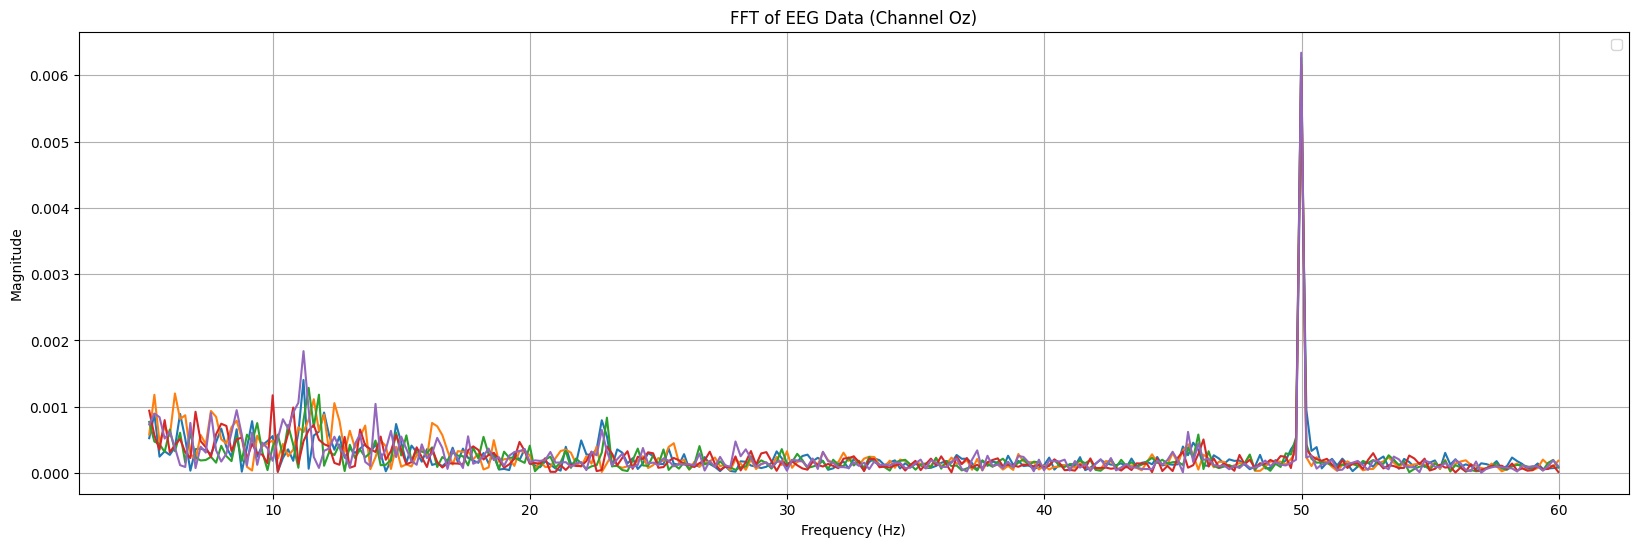

In [72]:
# Compute FFT
sampling_rate = 512
selected_data = Epochs['24Hz'].pick(['Oz']).get_data()
plt.figure(figsize=(20, 6))

for epoch in range(selected_data.shape[0]):
    fft_result = np.fft.fft(selected_data[epoch,0,:])
    fft_magnitude = np.abs(fft_result)  # Magnitude of the FFT
    fft_frequency = np.fft.fftfreq(selected_data.shape[2], 1/sampling_rate)  # Frequency axis

    # Filter the frequencies between 5 Hz and 60 Hz
    freq_mask = (fft_frequency >= 5) & (fft_frequency <= 60)

    # Apply the mask to filter the magnitudes and frequencies
    filtered_magnitude = fft_magnitude[freq_mask]
    filtered_frequency = fft_frequency[freq_mask]

    # Plot the FFT for this epoch
    plt.plot(filtered_frequency, filtered_magnitude)

# Customize the plot
plt.title(f'FFT of EEG Data (Channel Oz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()



In [73]:
fft_magnitude.shape

(2561,)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


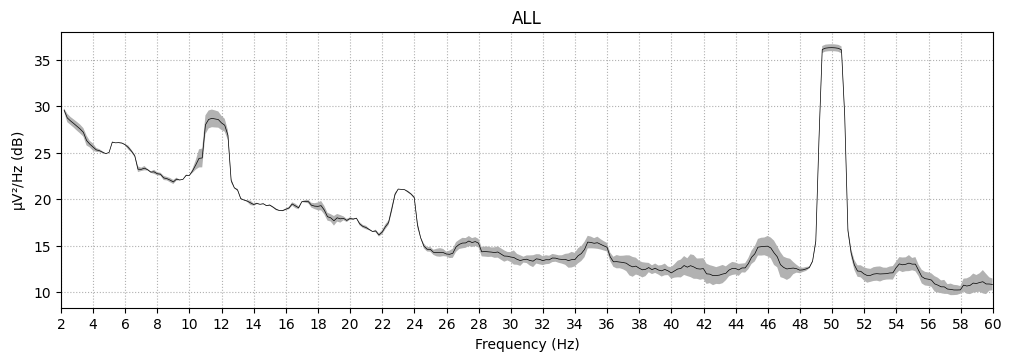

In [74]:
# Compute the PSD
psd = Epochs['12Hz','6Hz','24Hz','30Hz'].pick(['O1', 'Oz']).compute_psd(fmin=2.0, fmax=60.0)

# Plot the PSD
fig = psd.plot(average=True, amplitude=False, picks="data", exclude="bads")

# Customize the x-axis labels
ax = fig.axes[0]  # Get the axis of the first subplot
ax.set_xticks(np.arange(2, 61, 2))  # Set x-axis ticks from 2 to 60
ax.set_xticklabels(np.arange(2, 61, 2))  # Set x-axis labels from 2 to 60
ax.set_title('ALL')

plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


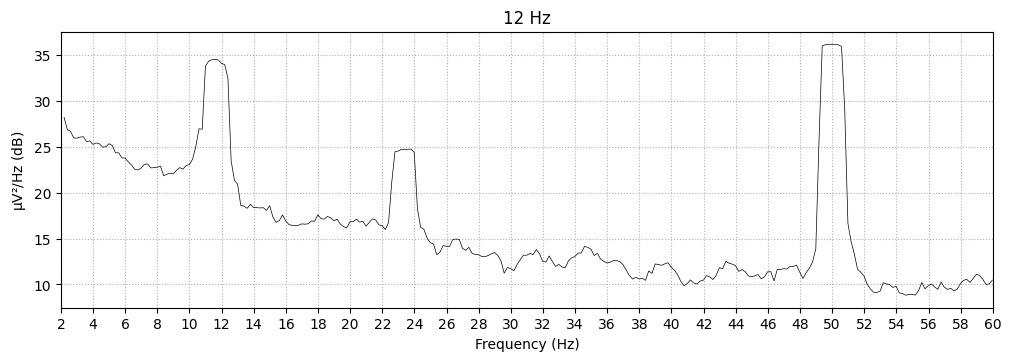

In [75]:
# Compute the PSD
psd = Epochs['12Hz'].pick(['Oz']).compute_psd(fmin=2.0, fmax=60.0)

# Plot the PSD
fig = psd.plot(average=True, amplitude=False, picks="data", exclude="bads")

# Customize the x-axis labels
ax = fig.axes[0]  # Get the axis of the first subplot
ax.set_xticks(np.arange(2, 61, 2))  # Set x-axis ticks from 2 to 60
ax.set_xticklabels(np.arange(2, 61, 2))  # Set x-axis labels from 2 to 60
ax.set_title('12 Hz')

plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


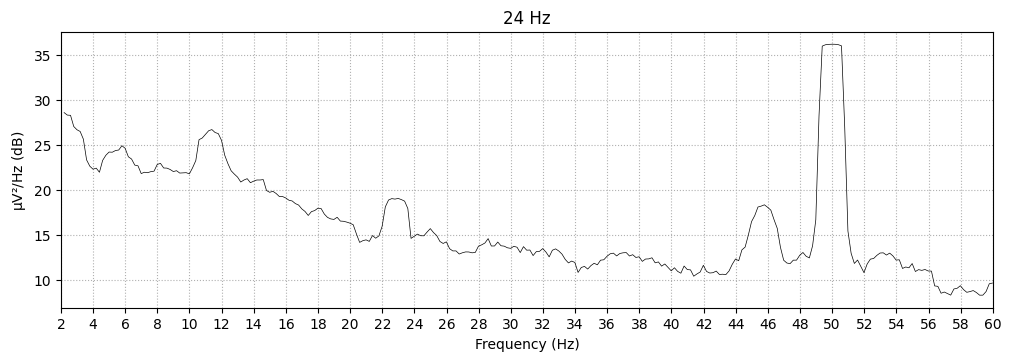

In [76]:
# Compute the PSD
psd = Epochs['24Hz'].pick(['Oz']).compute_psd(fmin=2.0, fmax=60.0)

# Plot the PSD
fig = psd.plot(average=True, amplitude=False, picks="data", exclude="bads")

# Customize the x-axis labels
ax = fig.axes[0]  # Get the axis of the first subplot
ax.set_xticks(np.arange(2, 61, 2))  # Set x-axis ticks from 2 to 60
ax.set_xticklabels(np.arange(2, 61, 2))  # Set x-axis labels from 2 to 60
ax.set_title('24 Hz')

plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


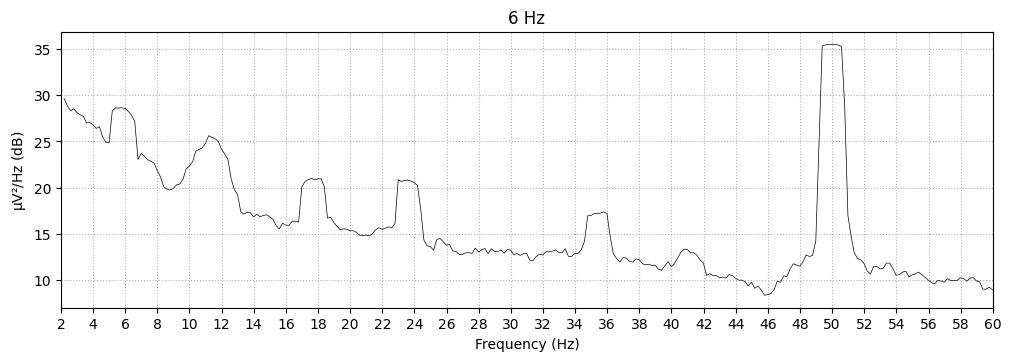

In [77]:
# Compute the PSD
psd = Epochs['6Hz'].pick(['Oz']).compute_psd(fmin=2.0, fmax=60.0)

# Plot the PSD
fig = psd.plot(average=True, amplitude=False, picks="data", exclude="bads")

# Customize the x-axis labels
ax = fig.axes[0]  # Get the axis of the first subplot
ax.set_xticks(np.arange(2, 61, 2))  # Set x-axis ticks from 2 to 60
ax.set_xticklabels(np.arange(2, 61, 2))  # Set x-axis labels from 2 to 60
ax.set_title('6 Hz')

plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


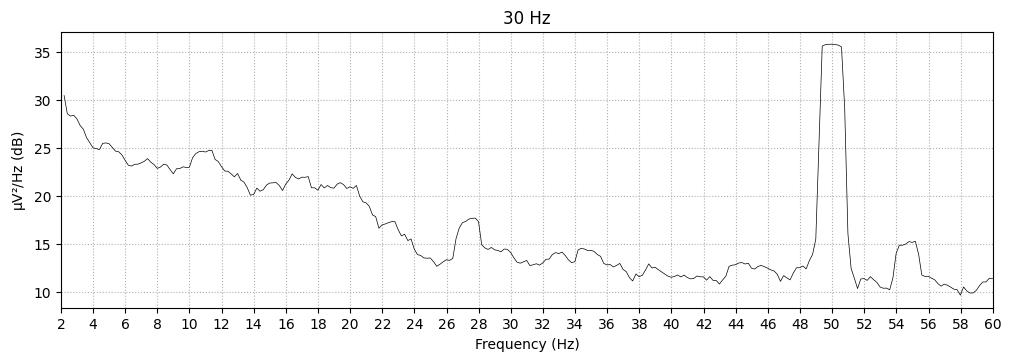

In [78]:
# Compute the PSD
psd = Epochs['30Hz'].pick(['Oz']).compute_psd(fmin=2.0, fmax=60.0)

# Plot the PSD
fig = psd.plot(average=True, amplitude=False, picks="data", exclude="bads")

# Customize the x-axis labels
ax = fig.axes[0]  # Get the axis of the first subplot
ax.set_xticks(np.arange(2, 61, 2))  # Set x-axis ticks from 2 to 60
ax.set_xticklabels(np.arange(2, 61, 2))  # Set x-axis labels from 2 to 60
ax.set_title('30 Hz')

plt.show()